# Online-Retail-Exploratory-Data-Analysis

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Extract data

In [2]:
# Extract data from Postgres DB function
def extract_data_from_dwh(sql_query):
    # establishing the connection
    conn = psycopg2.connect(
        database="dwh",
        user='postgres',
        password='123456',
        host='localhost',
        port= '5432'
    )

    # Creating a cursor object using the cursor()
    # method
    cursor = conn.cursor()
    
    cursor.execute(sql_query)
    # Extract all data from dwh
    data = cursor.fetchall()

    # Extract the column names
    col_names = []
    for col_name in cursor.description:
        col_names.append(col_name[0])

    df = pd.DataFrame(data, columns=col_names)

    # Commit your changes in the database
    conn.commit()
    #Closing the connection
    conn.close()
    
    return df

In [ ]:
# Extract Fact table from data warehouse
sql_query = '''
    SELECT * FROM fact_invoices;
'''
df_fact_invoices = extract_data_from_dwh(sql_query)
print(df_fact_invoices.info())
print(df_fact_invoices.head(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387938 entries, 0 to 387937
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   invoice_key  387938 non-null  int64  
 1   invoice_id   387938 non-null  object 
 2   datetime_id  387938 non-null  object 
 3   product_id   387938 non-null  object 
 4   customer_id  387938 non-null  int64  
 5   quantity     387938 non-null  int64  
 6   price        387938 non-null  float64
 7   total        387938 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 23.7+ MB
None
   invoice_key invoice_id   datetime_id product_id  customer_id  quantity  \
0            1     536365  201012010826      21730        17850         6   
1            2     536365  201012010826      22752        17850         2   
2            3     536365  201012010826      71053        17850         6   
3            4     536365  201012010826     84029E        17850         6   
4      

##### Detecting Outliers

In [19]:
sns.set_style('darkgrid')

<Axes: xlabel='price'>

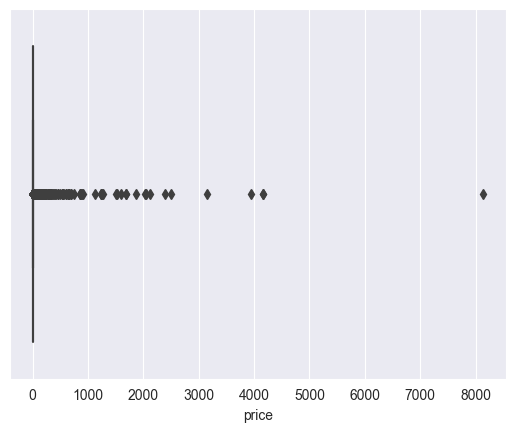

In [ ]:
# Check price data is have < 0 value?
sns.boxplot(x = df_fact_invoices['price'])

<Axes: xlabel='quantity'>

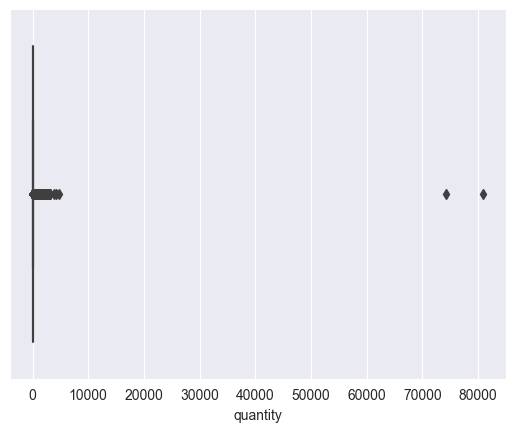

In [ ]:
# Quantity value
sns.boxplot(x = df_fact_invoices['quantity'])

### 2. Analyzing Sales Trends Over Time

##### 2.1. Monthly Sales Trend

In [6]:
sql_query = """
    SELECT 
        CONCAT(dd."year", '-', dd."month") AS year_month
        , SUM(fi.quantity) AS sum_quantity_product_sold
    FROM fact_invoices fi
    JOIN dim_date dd 
        ON dd.datetime_id = fi.datetime_id
    GROUP BY 
        dd."year"
        , dd."month"
"""
df_product_quantity_by_each_month = extract_data_from_dwh(sql_query)
print(df_product_quantity_by_each_month)

   year_month  sum_quantity_product_sold
0     2010-12                     312265
1      2011-1                     349098
2      2011-2                     265622
3      2011-3                     348503
4      2011-4                     292222
5      2011-5                     373601
6      2011-6                     363699
7      2011-7                     369420
8      2011-8                     398121
9      2011-9                     544897
10    2011-10                     593900
11    2011-11                     669051
12    2011-12                     287413


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


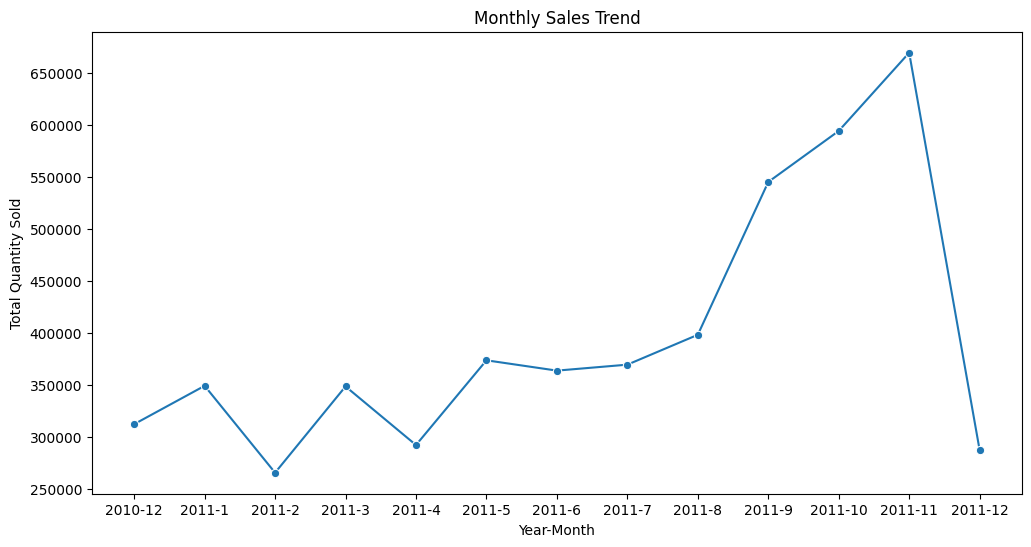

In [8]:
plt.figure(figsize=(12, 6))
year_month = df_product_quantity_by_each_month['year_month']
quantity = df_product_quantity_by_each_month['sum_quantity_product_sold']
sns.lineplot(x=year_month, y=quantity, marker='o')
plt.xlabel('Year-Month')
plt.ylabel('Total Quantity Sold')
plt.title('Monthly Sales Trend')
plt.show()

**Featured Trends**
- Steady growth: From January 2011 to November 2011, the number of products sold increased gradually, reaching a peak in November 2011 with 669,051 products.
- Lowest month: February 2011 with 265,622 products (possibly due to holidays or seasonal factors).
- Decline after the peak: After reaching a peak in November 2011, sales dropped sharply to 287,413 in December 2011 (due to data only up to December 9, 2011).

**Key Insight**
- September - November 2011 is the peak period, suitable for promotional campaigns.
- February 2011 has the lowest sales, need to consider stimulus strategies.

##### 2.2. Busiest days of the week

In [32]:
sql_query = """
    SELECT 
        dd.day_name
        , SUM(fi.quantity) AS sum_quantity_product_sold
    FROM fact_invoices fi
    JOIN dim_date dd 
        ON dd.datetime_id = fi.datetime_id
    GROUP BY dd.day_name
"""
df_product_quantity_by_day_of_week = extract_data_from_dwh(sql_query)

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']

df_product_quantity_by_day_of_week['day_name'] = pd.Categorical(df_product_quantity_by_day_of_week['day_name'], categories=day_order, ordered=True)
weekly_sales = df_product_quantity_by_day_of_week.sort_values('day_name').reset_index(drop=True)

print(weekly_sales)

    day_name  sum_quantity_product_sold
0     Monday                     769001
1    Tuesday                    1007859
2  Wednesday                     962417
3   Thursday                    1151845
4     Friday                     810218
5     Sunday                     466472


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


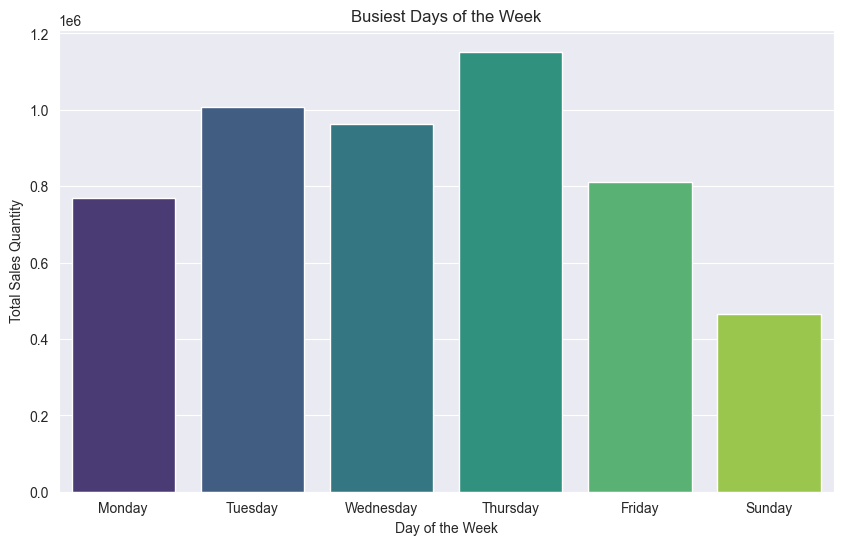

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(x=weekly_sales['day_name'], y=weekly_sales['sum_quantity_product_sold'], palette='viridis')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales Quantity')
plt.title('Busiest Days of the Week')
plt.show()

**Key Insights:**
- Busiest Day: Thursday
  - Sales Volume: 1,151,845 products sold (Highest)
  - Reason: This may be due to mid-week promotions, corporate purchases, or customers preparing for the weekend.

- Second Busiest Day: Tuesday
  - Sales Volume: 1,007,859 products sold
  - Reason: Customers may be catching up on shopping needs early in the week after the weekend.

- Slowest Day: Sunday
  - Sales Volume: 466,472 products sold (Lowest)
  - Reason: Fewer business operations or customer engagement on weekends.

**Actionable Insights for Business Strategy:**
- Maximize Promotions on Thursdays: Since Thursday has the highest sales, focus on launching major campaigns and exclusive offers on this day.
- Early Week Engagement (Tuesday-Wednesday): Utilize email marketing or loyalty incentives to sustain the high purchase volume mid-week.
- Boost Weekend Sales: Consider special discounts or free shipping on Sundays to encourage more transactions during the slowest period.

##### 2.3. Exploring Top-Selling Products and Countries:

In [36]:
sql_query = """
    SELECT 
        dc.country
        , SUM(fi.quantity) AS sum_quantity_product_sold
    FROM fact_invoices fi
    JOIN dim_customer dc 
        ON dc.customer_id = fi.customer_id
    GROUP BY dc.country
    ORDER BY SUM(fi.quantity) DESC
    LIMIT 10;
"""
df_product_quantity_by_country = extract_data_from_dwh(sql_query)
print(df_product_quantity_by_country)

          country  sum_quantity_product_sold
0  United Kingdom                    4256740
1     Netherlands                     200361
2            EIRE                     140275
3         Germany                     119261
4          France                     111471
5       Australia                      84551
6          Sweden                      36083
7     Switzerland                      29973
8           Spain                      29196
9           Japan                      26016


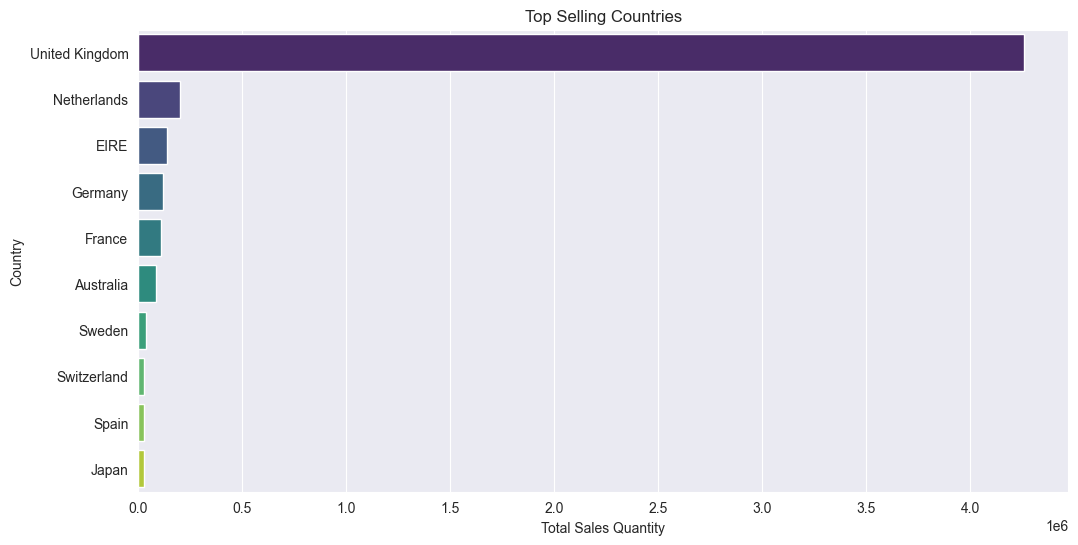

In [37]:
plt.figure(figsize=(12, 6))
sns.barplot(x=df_product_quantity_by_country['sum_quantity_product_sold'], y=df_product_quantity_by_country['country'], palette='viridis')
plt.xlabel('Total Sales Quantity')
plt.ylabel('Country')
plt.title('Top Selling Countries')
plt.show()

**Key Insights:**
- Dominant Market: United Kingdom
  - Sales Volume: 4,256,740 products (≈ 80% of total sales)
  - Insight: The UK is the primary market. Focus on maintaining customer satisfaction and optimizing logistics here.
- Secondary Markets: Netherlands, Ireland (EIRE), and Germany
  - Combined Sales: 459,897 products (≈ 8.6% of total sales)
  - Insight: These countries are key international markets. Consider localized marketing strategies and improving shipping efficiency.
- Emerging Markets: France, Australia, and Sweden
  - Sales Share: 5.4% combined
  - Insight: Opportunity to expand presence. Evaluate regional preferences and offer promotions to boost sales.
- Low-Volume Markets: Switzerland, Spain, Japan
  - Sales Share: 1.6% combined
  - Insight: Though contributing modestly to overall sales, these countries could benefit from targeted campaigns or exclusive products to increase engagement.

**Business Recommendations:**
- UK Strategy: Continue to prioritize and enhance customer service, warehouse efficiency, and promotional activities.
- Expand in Europe: Target high-potential countries like the Netherlands, Germany, and France with region-specific offers.
- Growth in Niche Markets: Explore ways to grow in Australia and Sweden through seasonal campaigns or partnerships.
- Localized Marketing: Tailor marketing messages and logistics for low-volume but promising regions (Spain, Japan, Switzerland).

### 3. RFM Analysis

In [7]:
# Get data
sql_query = """
WITH rfm_base AS(
	SELECT 
		fi.customer_id
		, MAX(dd.datetime) AS last_purchase_date
		, COUNT(DISTINCT fi.invoice_id) AS frequency
		, SUM(fi.total) AS monetary
	FROM fact_invoices fi
	JOIN dim_customer dc ON dc.customer_id = fi.customer_id
	JOIN dim_date dd ON dd.datetime_id = fi.datetime_id 
	GROUP BY fi.customer_id
), 
max_date AS(
	SELECT MAX(DISTINCT dd.datetime) AS max_date
	FROM fact_invoices fi
	JOIN dim_date dd ON dd.datetime_id = fi.datetime_id
),
rfm_calculated AS(
	SELECT
		*
		, EXTRACT(DAY FROM ((SELECT max_date FROM max_date) - last_purchase_date)::interval) AS recency
		, NTILE(5) OVER (ORDER BY EXTRACT (DAY FROM ((SELECT max_date FROM max_date) - last_purchase_date)::interval) DESC) AS r_score
	    , NTILE(5) OVER (ORDER BY frequency) AS f_score
	    , NTILE(5) OVER (ORDER BY monetary) AS m_score
	FROM rfm_base
),
rfm_segment AS (
	SELECT
		customer_id
		, recency
		, frequency
		, monetary
		, r_score
		, f_score
		, m_score
		, (CAST(r_score AS VARCHAR) || CAST(f_score AS VARCHAR) || CAST(m_score AS VARCHAR)) AS rfm_score
	FROM rfm_calculated
	ORDER BY rfm_score
)
SELECT * FROM rfm_segment
"""
df_rfm = extract_data_from_dwh(sql_query)
print(df_rfm.head())

   customer_id recency  frequency  monetary  r_score  f_score  m_score  \
0        16583     373          1    233.45        1        1        1   
1        12791     373          1    192.60        1        1        1   
2        13747     373          1     79.60        1        1        1   
3        17908     373          1    243.28        1        1        1   
4        14237     372          1    161.00        1        1        1   

  rfm_score  
0       111  
1       111  
2       111  
3       111  
4       111  


##### Let’s see the best and the worst customers:

In [8]:
df_rfm[df_rfm['rfm_score'] == '555'].head()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score
3990,16133,3,33,14589.04,5,5,5,555
3991,17365,12,8,4801.56,5,5,5,555
3992,17920,3,17,4204.10,5,5,5,555
3993,18283,3,16,2094.88,5,5,5,555
3994,16592,3,16,4113.68,5,5,5,555


In [9]:
df_rfm[df_rfm['rfm_score'] == '111'].head()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score
0,16583,373,1,233.45,1,1,1,111
1,12791,373,1,192.60,1,1,1,111
2,13747,373,1,79.60,1,1,1,111
3,17908,373,1,243.28,1,1,1,111
4,14237,372,1,161.00,1,1,1,111


##### CREATING RFM SEGMENTS

In [10]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

As the monetary is a similar value to frequency, it is not considered in scoring. Recency and frequency points are obtained with the following code:
- To segment the customers using “Recency” and “Frequency” values.

In [11]:
df_rfm['rfm_segment'] = df_rfm['r_score'].astype(str) + df_rfm['f_score'].astype(str)
df_rfm['rfm_segment'].head()

0    11
1    11
2    11
3    11
4    11
Name: rfm_segment, dtype: object

Pull the value corresponding to the ranges of the score in the dictionary defined in ‘seg_map’, and add it as a new column named “Segment”

In [12]:
#Creating Segment Variable 
df_rfm['rfm_segment'] = df_rfm['rfm_segment'].replace(seg_map, regex=True)
df_rfm.head()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,rfm_segment
0,16583,373,1,233.45,1,1,1,111,hibernating
1,12791,373,1,192.60,1,1,1,111,hibernating
2,13747,373,1,79.60,1,1,1,111,hibernating
3,17908,373,1,243.28,1,1,1,111,hibernating
4,14237,372,1,161.00,1,1,1,111,hibernating


Now our data frame is ready and all the customers are grouped. We can retrieve data of all the groups one by one and save them as new data frames. For example, let us do this for the ‘Need Attention’ segment:

In [13]:
df_rfm[df_rfm['rfm_segment'] == 'need_attention'].head()

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,rfm_segment
2080,15516,44,3,62.43,3,3,1,331,need_attention
2081,13666,59,3,84.65,3,3,1,331,need_attention
2082,17024,44,3,95.85,3,3,1,331,need_attention
2083,17483,64,3,414.04,3,3,2,332,need_attention
2084,15121,49,2,457.72,3,3,2,332,need_attention


In [14]:
#Descriptive Statistics of RFM Segments 
df_rfm[['rfm_segment', 'recency', 'frequency', 'monetary']].groupby("rfm_segment").agg(['mean', 'count'])

recency        frequency           monetary      
                           mean count       mean count         mean count
rfm_segment                                                              
about_to_sleep        50.982558   344   1.142442   344   379.333110   344
at_Risk              148.580645   589   2.879457   589  1215.013280   589
cant_loose           129.246154    65   8.353846    65  2812.722000    65
champions              4.904836   641  12.294852   641  6781.629844   641
hibernating          216.917745  1082   1.107209  1082   416.995334  1082
loyal_customers        32.48995   796   6.575377   796  2937.323896   796
need_attention        49.974747   198   2.318182   198   959.654899   198
new_customers          6.119048    42   1.000000    42   376.133095    42
potential_loyalists   15.707819   486   2.039095   486  1042.834733   486
promising             22.473684    95   1.000000    95   352.601263    95

In [ ]:
import plotly.express as px
#Top 10 most preferred products
segments = df_rfm['rfm_segment'].value_counts()

fig = px.bar(
    x = segments.index,
    y = segments.values,
    color = segments.index,
    text = segments.values,
    title = "RFM Segments"
)
fig.update_layout(
    xaxis_title="Segment",
    yaxis_title="Count",
    font=dict(size=15, family="Arial"),
    title_font=dict(size=20, family="Arial")
)
fig.show()

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:1985: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


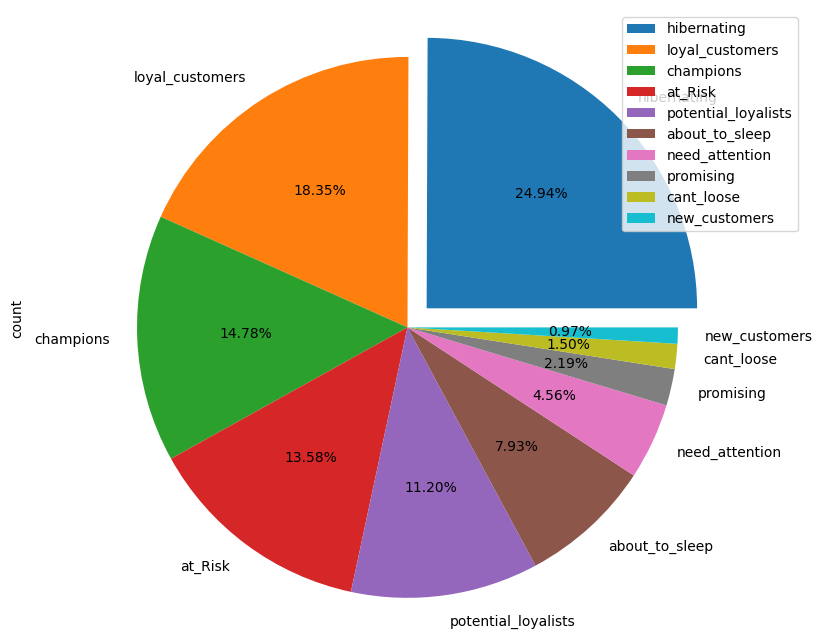

In [16]:
plt.figure(figsize = (10, 8), )
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)

segments.plot(
    kind = 'pie',
    color=segments.index,
    explode = explode,
    autopct = '%1.2f%%')
plt.axis('equal')
plt.legend(labels = segments.index, loc = "best")
plt.show()

### Report
##### To exemplify, we can choose the 3 groups to suggest actions for them.

1. **Can’t Lose Segment** [R(1–2), F(4–5)]:
- There are **65** customers in this group.
- They have not been shopping for an average of **~129** days.
- They shopped an average of **~8** times.
- We have gained an average of 2812.72 pounds from them.

This is a group we need to re-gain no matter because they are the customers which frequently shopped for big amounts but long time ago. We need to remind ourselves to them. We can send them campaign mails where we offer discounts on the products similar to what they have bought before. We can also send small surveys to get feedback about their shopping experience. We can make corrections based on the survey results. We can offer them renewals or newer products as well.

2. **Need Attention Segment** [R(2–3), F(2–3)]:
- There are **198** customers in this group.
- They have not been shopping for an average of **~50** days.
- They shopped an average of **~2** times.
- We have gained an average of **959.65** pounds from them.

These customers have average recency and frequency scores. We can win them with small effort because they have spent good amount of money per transaction and this means the product prices is not a big issue for them. They just stopped shopping for some reason so we need to find out the reason for it and we can remind ourselves to them by offering them special discounts and free fast deliveries for limited time. This way, we can increase their shopping frequencies. We can also let them know that they are only few steps away from becoming a loyal customer where we can offer more discounts. This can encourage them to buy more frequently.

3. **At Risk Segment** [R(1–2), F(3–4)]:
- There are **589** customers at risk.
- They have not been shopping for an average of **~149** days.
- They shopped an average of **~3** times.
- We have gained an average of **1215** pounds from them.

These are the customers who have not shopped for a long time. They are the most important group to pay attention after the ‘can’t lose’ group because this group also shopped frequently but long time ago. Now, they are about to leave us. We can contact them by email or by phone to find out the reason why they have stopped buying from us. Seeing the average amount of their purchases, it seems the money is not the main problem for them. It could be the delivery problems or offers from the competitors. We can offer them better and more convenient delivery terms (cheaper and faster). We can offer them big discounts for their purchases over a certain amount. They might have problems with the products they have purchased so we can offer them renewals or provide them helpful manuals.

### Conclusion
RFM analysis, which is based on customers’ past behavior, is a powerful and frequently used method for companies. Understanding it and knowing how to use it is very important for increasing the sales because it helps to understand your customers and develop personalized marketing strategies for them.